## Basic Colab Setup

In [0]:
# Mounting google drive to import files from drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Colab setup
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
# initializing data directories - please give your local directory name in case you are running on local machine
DATA_DIR = '/content/drive/My Drive/Projects/ASHRAE/'
ROOT_DIR = '/content/'

In [0]:
# importing needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime
import gc
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data Import and Cleaning

In [0]:
# importing the csv files from drive
building_meta = pd.read_csv(DATA_DIR+'building_metadata.csv')
weather = pd.read_csv(DATA_DIR+'weather_train.csv')
train= pd.read_csv(DATA_DIR+'train.csv')

In [0]:
# check nulls in weather data - weather is one of the key predictors of power consumption
weather.isnull().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [0]:
# generic imputation will not make sense since different sites will have different weather patterns at different time points  
# weather data imputation - imputing with site level + time level mean for all the sites

def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df

# adding weather lag to data since in our day to day life weather at one point directs  our power consumption in immediate future too
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'precip_depth_1_hr']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [0]:
# update weather dataframe 
weather = fill_weather_dataset(weather)
weather.drop(columns=["dew_temperature","sea_level_pressure", "wind_direction", "wind_speed"], inplace=True)
add_lag_feature(weather, window=3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


In [0]:
# merge all the dataframes in one central repository
temp = train.merge(right = building_meta, on = 'building_id', how = 'left')
train_all = temp.merge(right = weather, on = ['site_id','timestamp'], how = 'left')

In [0]:
print( "Current train data memory consumption:", train_all.memory_usage().sum() / 1024**2)

Current train data memory consumption: 2467.78564453125


In [0]:
## The data size is huge; we need to reduce the size for faster computation
## Function to reduce the DF size by freeing up memory usage from each column - e.g - converting int64 to int32 or int8 based on the data stored in each column
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
# Reduce memory size
train_all = reduce_mem_usage(train_all)

Mem. usage decreased to 1349.57 Mb (45.3% reduction)


In [0]:
# Garbage collector frees up memory not in use
gc.collect()

0

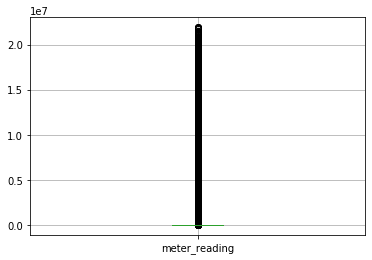

In [0]:
# checking for outliers, boosting models are susceptible to outliers so we will get rid of it from the target variable before modeling and analysis
train_all.boxplot(column = ['meter_reading'])

In [0]:
# meter_reading quick stats
train_all['meter_reading'].describe()

count    2.021610e+07
mean     1.988706e+03
std      1.532159e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

In [0]:
# how many data points are more than 3 std away
train_all[train_all['meter_reading'] > 50000].shape

(13619, 24)

In [0]:
# filtering outliers i.e data points 3 standard deviations away
train_all = train_all[train_all['meter_reading'] < 50000]

In [0]:
# checking if there are any data points with electricity meter reading as 0
train_all[((train_all['meter_reading'] == 0) & (train_all['meter'] == 0))].shape

(530169, 24)

In [0]:
# electricity meter reading shouldn't be 0, filtering out all those rows
train_all = train_all[~((train_all['meter_reading'] == 0) & (train_all['meter'] == 0))]

## EDA & Feature Enginnering

In [0]:
# extacting features from date column
train_all["timestamp"] = pd.to_datetime(train_all["timestamp"],format="%Y-%m-%d %H:%M:%S")
train_all['hour'] = train_all['timestamp'].dt.hour
train_all['dayofweek'] = train_all['timestamp'].dt.dayofweek
train_all['month'] = train_all['timestamp'].dt.month
train_all['dayofmonth'] = train_all['timestamp'].dt.day

In [0]:
train_all.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,precip_depth_1_hr,air_temperature_mean_lag3,air_temperature_max_lag3,air_temperature_min_lag3,air_temperature_std_lag3,cloud_coverage_mean_lag3,cloud_coverage_max_lag3,cloud_coverage_min_lag3,cloud_coverage_std_lag3,precip_depth_1_hr_mean_lag3,precip_depth_1_hr_max_lag3,precip_depth_1_hr_min_lag3,precip_depth_1_hr_std_lag3,hour,dayofweek,month,dayofmonth
45,46,0,2016-01-01,53.239700,0,Retail,9045,2016.0,NaN,25.000000,6.0,-0.17395,25.000000,25.000000,25.000000,NaN,6.0,6.0,6.0,NaN,-0.17395,-0.17395,-0.17395,NaN,0,4,1,1
72,74,0,2016-01-01,43.001301,0,Parking,387638,1997.0,NaN,25.000000,6.0,-0.17395,25.000000,25.000000,25.000000,NaN,6.0,6.0,6.0,NaN,-0.17395,-0.17395,-0.17395,NaN,0,4,1,1
91,93,0,2016-01-01,52.420601,0,Office,33370,1982.0,NaN,25.000000,6.0,-0.17395,25.000000,25.000000,25.000000,NaN,6.0,6.0,6.0,NaN,-0.17395,-0.17395,-0.17395,NaN,0,4,1,1
103,105,0,2016-01-01,23.303600,1,Education,50623,NaN,5.0,3.800781,0.0,0.00000,3.800781,3.800781,3.800781,NaN,0.0,0.0,0.0,NaN,0.00000,0.00000,0.00000,NaN,0,4,1,1
104,106,0,2016-01-01,0.374600,1,Education,5374,NaN,4.0,3.800781,0.0,0.00000,3.800781,3.800781,3.800781,NaN,0.0,0.0,0.0,NaN,0.00000,0.00000,0.00000,NaN,0,4,1,1


Text(0.5, 1.0, 'Percentage share of each building type')

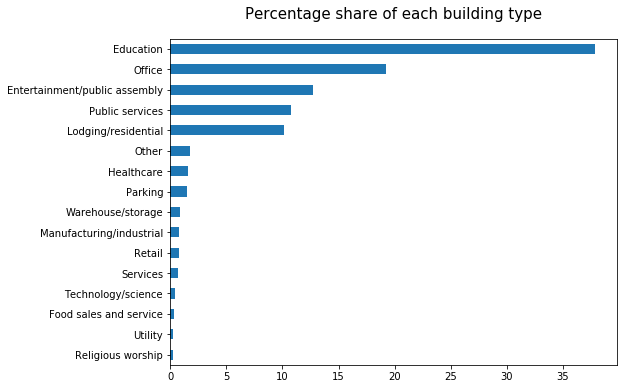

In [0]:
# Education building have maximum presence; ~35% buildings are educational
plt.figure(figsize=(8,6))
temp_df = (building_meta['primary_use'].value_counts(normalize = True)*100).sort_values()
temp_df.plot(kind = 'barh')
plt.title('Percentage share of each building type', pad = 20, fontsize = 15)

Text(0, 0.5, ' ')

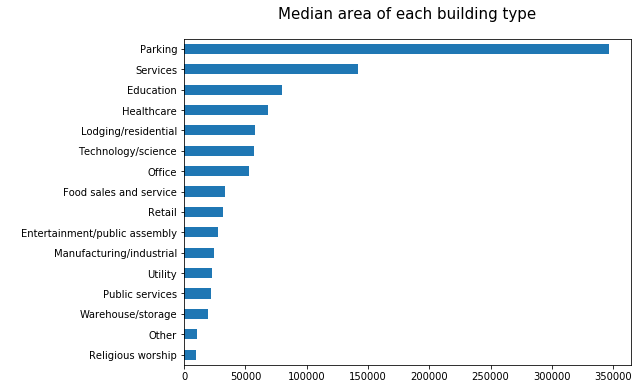

In [0]:
# parking takes the most space
plt.figure(figsize=(8,6))
building_meta.groupby('primary_use')['square_feet'].median().sort_values().plot(kind = 'barh')
plt.title('Median area of each building type', pad = 20, fontsize = 15)
plt.ylabel(' ')

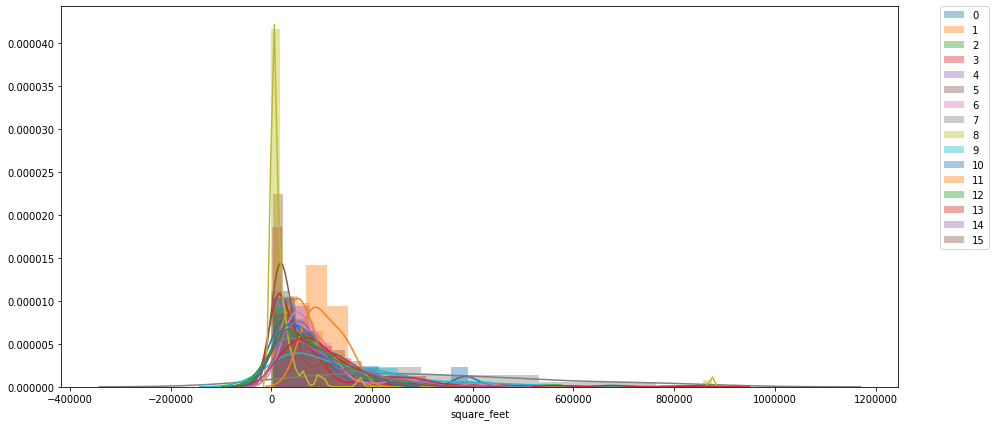

In [0]:
#Looking at the distribution of square feet - We can see that buildings in site 8 and 5 are smaller
plt.figure(figsize=(15,7))
for i in range(0,16):
    build_met=building_meta[building_meta['site_id']==i]
    sns.distplot(build_met['square_feet'],label=i)
    i=i+1
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [0]:
# summary of building at site level
building_meta.groupby(['site_id','primary_use'])['floor_count','square_feet'].mean().dropna()

floor_count    square_feet
site_id primary_use                                              
1       Education                         6.727273   70999.863636
        Entertainment/public assembly     6.000000   64024.000000
        Lodging/residential               8.600000   68277.500000
        Office                            6.562500   51966.625000
        Public services                   6.000000   87430.000000
4       Education                         5.727273   91031.696970
        Entertainment/public assembly     3.666667   93878.222222
        Lodging/residential               5.000000   91791.250000
        Parking                           2.666667  135022.000000
        Public services                   4.666667  119446.333333
        Technology/science                4.500000   43200.500000
        Utility                           2.000000   23432.000000
5       Education                         2.163265   54393.367347
        Entertainment/public assembly     2.444444   33894.944444
        Healthcare                        1.000000   18471.000000
        Lodging/residential               3.000000    7589.000000
        Manufacturing/industrial          1.666667   33626.333333
        Office                            2.454545   60568.545455
        Other                             1.000000    5769.000000
        Public services                   3.200000   32631.800000
7       Education                         8.733333  323634.533333
8       Entertainment/public assembly     1.000000   44610.250000
        Office                            1.000000   42611.571429
        Other                             1.111111   25689.000000
        Public services                   1.000000   16025.964286
        Warehouse/storage                 1.000000   15499.500000
10      Education                         2.214286   88771.714286
        Entertainment/public assembly     2.500000  109405.000000
        Lodging/residential               1.666667   58659.666667
        Office                            1.600000   29943.800000
        Other                             1.000000    6397.333333
        Technology/science                6.000000  109263.000000
12      Education                         3.333333   97051.650000
        Office                            2.000000   41216.111111
        Retail                            1.500000   31143.333333

Text(0.5, 1.0, 'Buildings in each site')

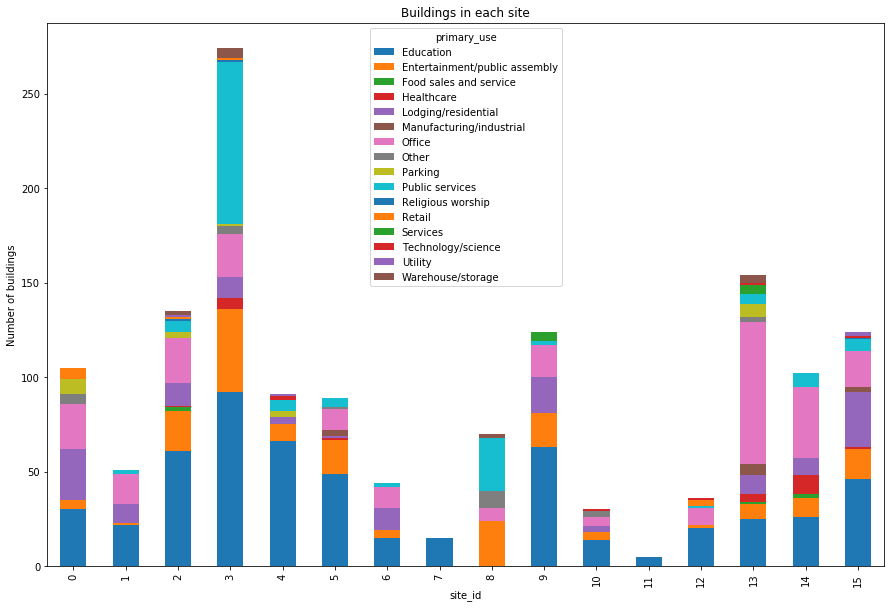

In [0]:
# Sites 7 & 11 predominantly have educational buildings while Site 13 mostly has office buildings
pd.crosstab(index=building_meta['site_id'],columns=building_meta['primary_use'], dropna=True).plot(kind='bar', stacked=True, figsize=(15,10))
plt.ylabel('Number of buildings')
plt.title('Buildings in each site')

Text(0, 0.5, 'Floor Count')

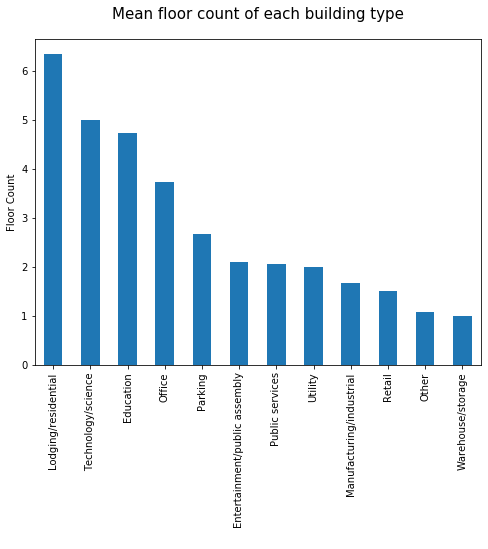

In [0]:
# Residential/Lodging are tallest
plt.figure(figsize=(8,6))
building_meta.groupby('primary_use')['floor_count'].mean().sort_values(ascending = False)[:12].plot(kind = 'bar')
plt.title('Mean floor count of each building type', pad = 20, fontsize = 15)
plt.xlabel(' ')
plt.ylabel('Floor Count')

Text(0, 0.5, 'Area ')

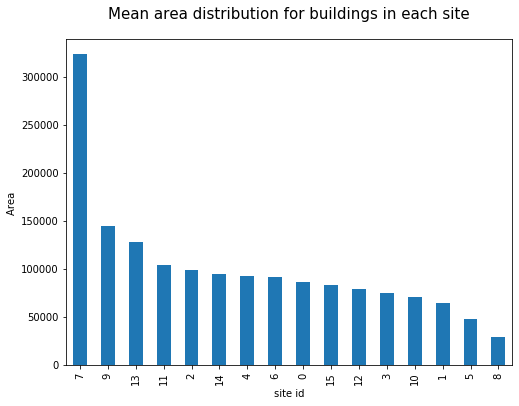

In [0]:
# Site 7 has the most spread buildings
plt.figure(figsize=(8,6))
building_meta.groupby('site_id')['square_feet'].mean().sort_values(ascending = False).plot(kind = 'bar')
plt.title('Mean area distribution for buildings in each site', pad = 20, fontsize = 15)
plt.xlabel('site id')
plt.ylabel('Area ')

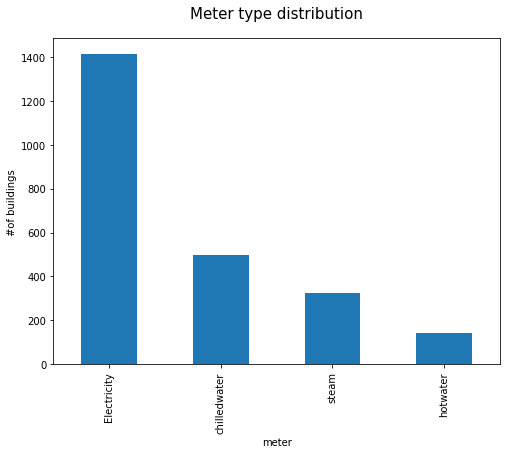

In [0]:
# Electricty meter as expected is omnipresent
plt.figure(figsize=(8,6))
train_all.groupby('meter')['building_id'].nunique().plot(kind = 'bar')
plt.title('Meter type distribution', fontsize = 15, pad = 20)
# plt.xlabel('meter type')
plt.ylabel('#of buildings')
plt.xticks(np.arange(4), ('Electricity', 'chilledwater', 'steam', 'hotwater'));

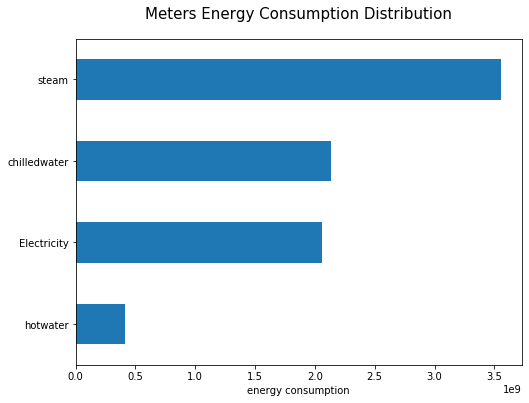

In [0]:
# interestingly, steam with minimal presence consumes the most of energy
plt.figure(figsize=(8,6))
train_all.groupby('meter')['meter_reading'].sum().sort_values().plot(kind = 'barh')
plt.title('Meters Energy Consumption Distribution', fontsize = 15, pad = 20)
plt.ylabel('')
plt.xlabel('energy consumption')
plt.yticks(np.arange(4), ('hotwater', 'Electricity', 'chilledwater', 'steam'));

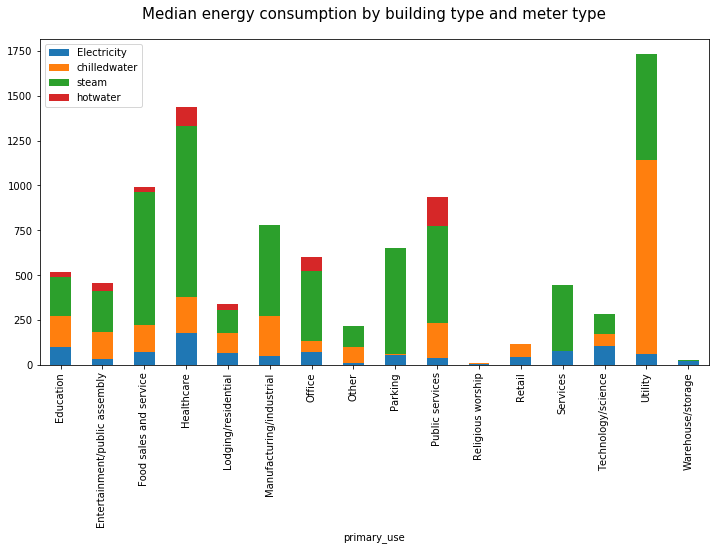

In [0]:
# energy consumption across building types - Chilled water was the most consumed energy in utility buildings
train_all.groupby(['primary_use', 'meter'])['meter_reading'].median().unstack().plot(kind = 'bar', stacked = True, figsize = (12,6))
plt.title('Median energy consumption by building type and meter type', fontsize = 15, pad = 20)
plt.legend(labels=['Electricity', 'chilledwater', 'steam', 'hotwater'])

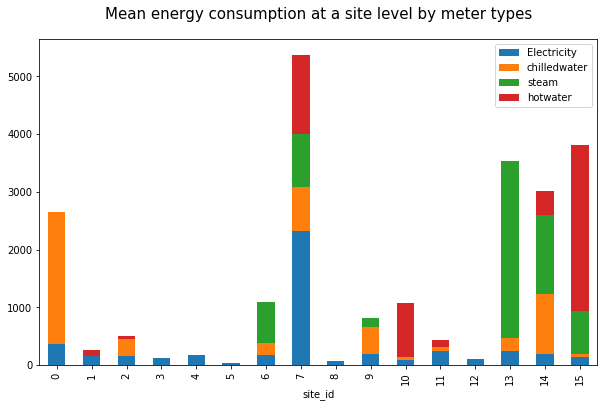

In [0]:
# site0, site 7, site 13 and site 15 needs to be looked upon
train_all.groupby(['site_id', 'meter'])['meter_reading'].mean().unstack().plot(kind = 'bar', stacked = True, figsize = (10,6))
plt.title('Mean energy consumption at a site level by meter types', fontsize = 15, pad = 20)
plt.legend(labels=['Electricity', 'chilledwater', 'steam', 'hotwater'])

Text(0.5, 1.0, 'Hourly distribution of energy consumption')

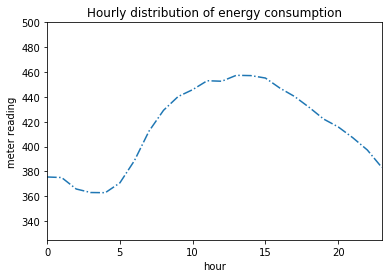

In [0]:
# higher consumption during day
train_all.groupby('hour')['meter_reading'].mean().plot(linestyle='-.').axes.set_ylim(325,500)
plt.ylabel('meter reading')
plt.title('Hourly distribution of energy consumption')

Text(0.5, 1.0, 'Weekly distribution of energy consumption')

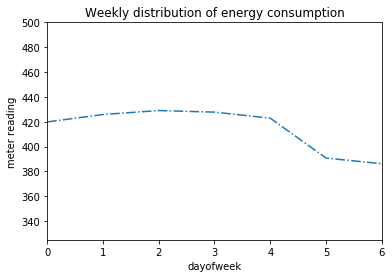

In [0]:
# higher consumption during weekdays
train_all.groupby('dayofweek')['meter_reading'].mean().plot(linestyle='-.').axes.set_ylim(325,500)
plt.ylabel('meter reading')
plt.title('Weekly distribution of energy consumption')

Text(0.5, 1.0, 'Month wise distribution of energy consumption')

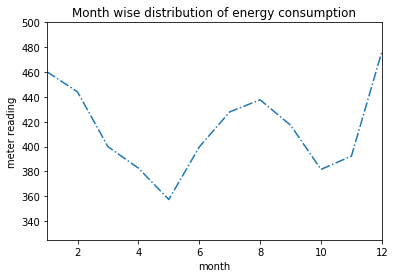

In [0]:
# Pleasant months see low consumption as expected
train_all.groupby('month')['meter_reading'].mean().plot(linestyle='-.').axes.set_ylim(325,500)
plt.ylabel('meter reading')
plt.title('Month wise distribution of energy consumption')

Text(0.5, 1.0, 'Impact of Air Temperature on Power Consumption')

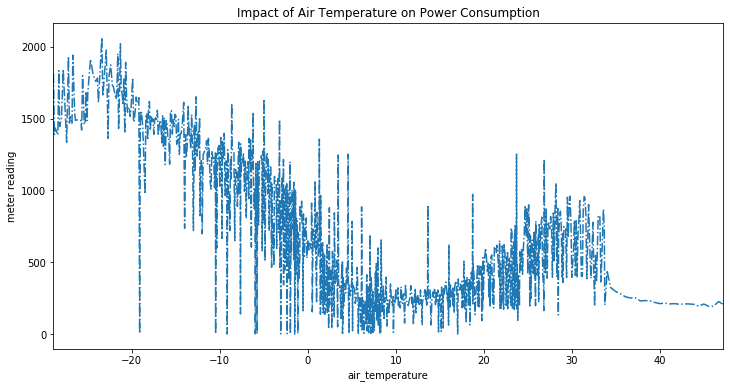

In [0]:
# a clear trend, pleasant temperature results in lower consumption
plt.figure(figsize=(12,6))
train_all.groupby('air_temperature')['meter_reading'].mean().plot(linestyle='-.')
plt.ylabel('meter reading')
plt.title('Impact of Air Temperature on Power Consumption')

In [0]:
# let's see if we can get some patterns from air temperature data
def plot_feature_distribution(interval, feature):
  fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(20, 15))

  for each in train_all['site_id'].unique():
    row = int(each / 4)
    col = each%4
    temp_df = train_all[train_all['site_id'] == each]
    temp_df.groupby(interval)[feature].mean().plot(ax=axes[row,col])

    missing = 100 / len(temp_df) * temp_df[feature].isnull().sum()
    if missing !=0:
      axes[row, col].set_title(f"Site {each} - {missing :.2f}% nulls", fontsize=12, color="red")
    else:
      axes[row, col].set_title(f"Site {each} - no nulls", fontsize=12, color="green")

    axes[row, col].set_xlabel("")
    fig.suptitle(f"{feature} distribution for all sites - {interval} level", fontsize=18)
    fig.subplots_adjust(top=0.93)

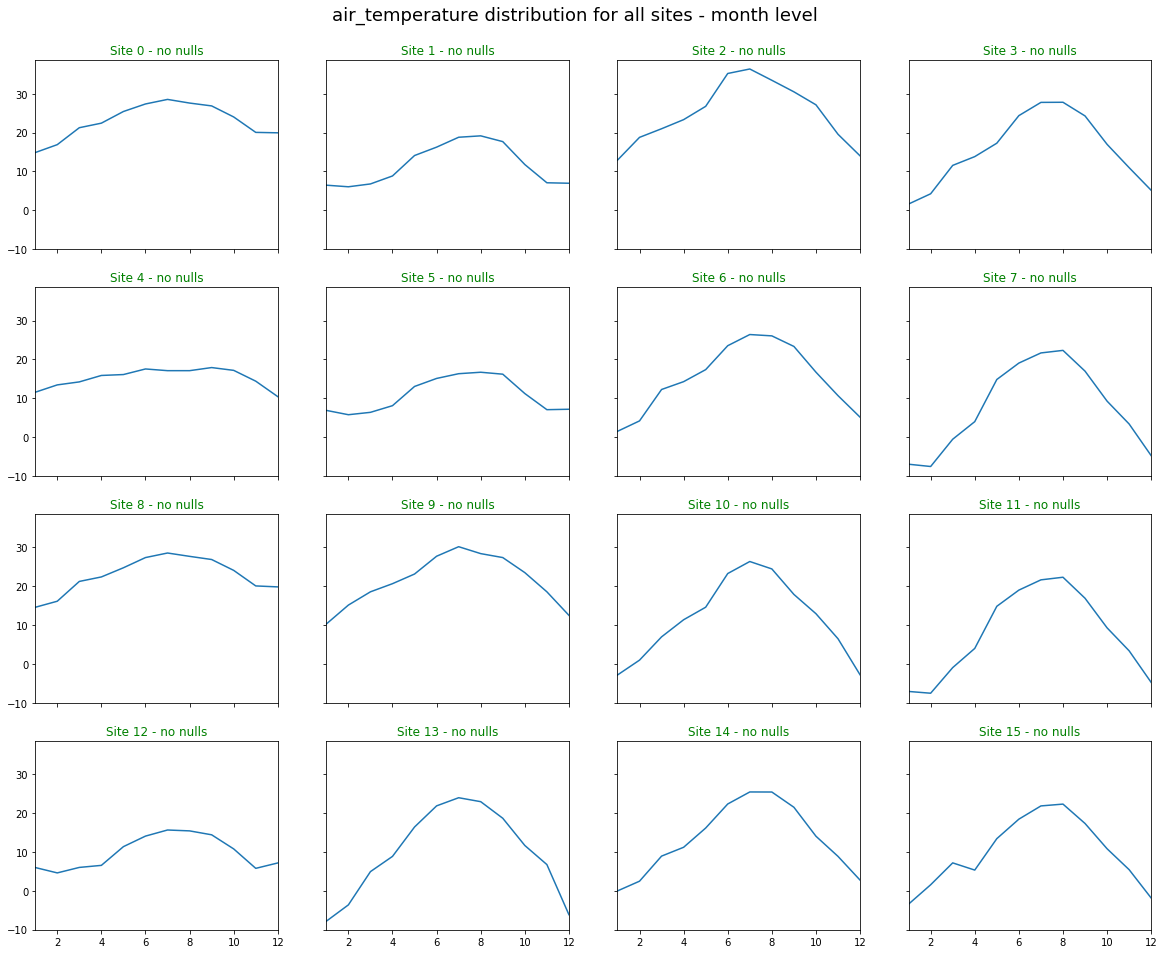

In [0]:
# Site 2 is the hottest and Site 4 shows the least variation in temperature (10 - 20 C) throughout the year. 
# Sites 1-6, 8, 9, 12 do not have any sub zero temperatures recorded
# We can see that that the weather patterns are different across most sites as the data is taken across vast areas of lands such 
# as different states affecting the energy consumption. Some 7& 11 have similar weather patterns 
plot_feature_distribution('month', 'air_temperature')

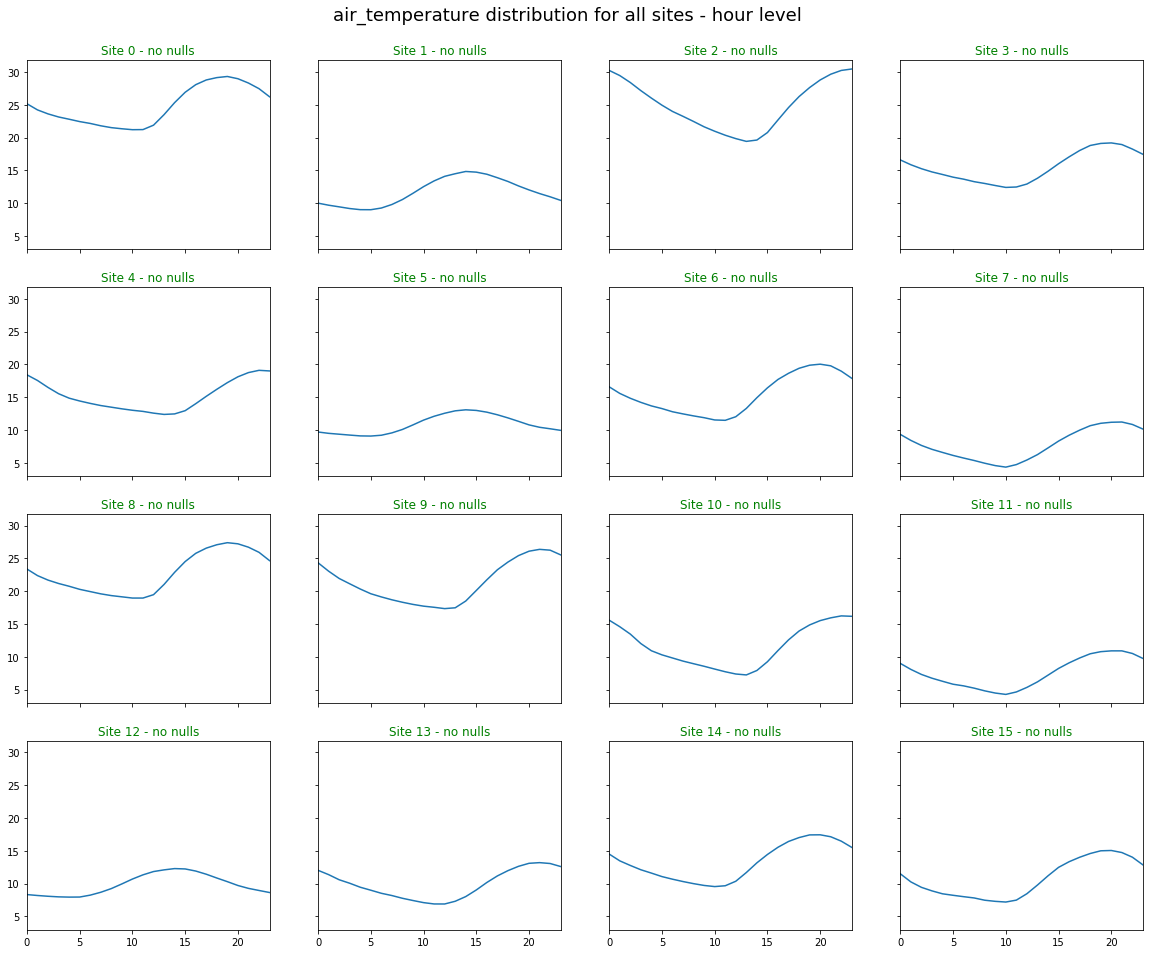

In [0]:
# Other than sites 1, 5 and 12, all of them seem to have an abnormal distribution, with temperatures peaking at 8PM and in some cases midnight also
plot_feature_distribution('hour', 'air_temperature')

In [0]:
# label encoding primary_use column; to be used in LGBM model
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(train_all['primary_use'])

train_all['primary_use'] = pd.Series(le.transform(train_all['primary_use']))

In [0]:
# taking log to contain the skew
train_all['square_feet'] = np.log(train_all['square_feet'] + 1)
train_all['meter_reading'] = np.log(train_all['meter_reading'] + 1)

In [0]:
# dropping non useful columns
train_all.drop(columns=["timestamp","year_built","floor_count"], inplace=True)
train_all.reset_index(drop = True, inplace = True)

In [0]:
# let's have a look at the final data
train_all.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,precip_depth_1_hr,air_temperature_mean_lag3,air_temperature_max_lag3,air_temperature_min_lag3,air_temperature_std_lag3,cloud_coverage_mean_lag3,cloud_coverage_max_lag3,cloud_coverage_min_lag3,cloud_coverage_std_lag3,precip_depth_1_hr_mean_lag3,precip_depth_1_hr_max_lag3,precip_depth_1_hr_min_lag3,precip_depth_1_hr_std_lag3,hour,dayofweek,month,dayofmonth
0,46,0,3.993413,0,9.0,9.110078,25.000000,6.0,-0.17395,25.000000,25.000000,25.000000,NaN,6.0,6.0,6.0,NaN,-0.17395,-0.17395,-0.17395,NaN,0,4,1,1
1,74,0,3.784219,0,0.0,12.867830,25.000000,6.0,-0.17395,25.000000,25.000000,25.000000,NaN,6.0,6.0,6.0,NaN,-0.17395,-0.17395,-0.17395,NaN,0,4,1,1
2,93,0,3.978196,0,0.0,10.415443,25.000000,6.0,-0.17395,25.000000,25.000000,25.000000,NaN,6.0,6.0,6.0,NaN,-0.17395,-0.17395,-0.17395,NaN,0,4,1,1
3,105,0,3.190624,1,0.0,10.832181,3.800781,0.0,0.00000,3.800781,3.800781,3.800781,NaN,0.0,0.0,0.0,NaN,0.00000,0.00000,0.00000,NaN,0,4,1,1
4,106,0,0.318163,1,0.0,8.589514,3.800781,0.0,0.00000,3.800781,3.800781,3.800781,NaN,0.0,0.0,0.0,NaN,0.00000,0.00000,0.00000,NaN,0,4,1,1


In [0]:
train_all.columns

Index(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'air_temperature', 'cloud_coverage', 'precip_depth_1_hr',
       'air_temperature_mean_lag3', 'air_temperature_max_lag3',
       'air_temperature_min_lag3', 'air_temperature_std_lag3',
       'cloud_coverage_mean_lag3', 'cloud_coverage_max_lag3',
       'cloud_coverage_min_lag3', 'cloud_coverage_std_lag3',
       'precip_depth_1_hr_mean_lag3', 'precip_depth_1_hr_max_lag3',
       'precip_depth_1_hr_min_lag3', 'precip_depth_1_hr_std_lag3', 'hour',
       'dayofweek', 'month', 'dayofmonth'],
      dtype='object')

In [0]:
# noting down categorical features - will be used in modeling
categorical_feature = ['building_id','meter','site_id','primary_use','hour', 'dayofweek', 'month','dayofmonth']

In [0]:
# initially we trained by divinding data in first half and second half of year and then combine the results from both the models
# but we didn't get fruitful results. We went ahead with k-fold CV for our final model

# train_h1 = train_all[train_all['month']<=6]
# train_h2 = train_all[train_all['month']>6]

## Prepare Test Data

Apply all the cleaning and feature engineerig steps to test data as well

In [0]:
# building_meta = pd.read_csv(DATA_DIR+'building_metadata.csv')
weather_test = pd.read_csv(DATA_DIR+'weather_test.csv')
weather_test = fill_weather_dataset(weather_test)
weather_test.drop(columns=["dew_temperature","sea_level_pressure", "wind_direction", "wind_speed"], inplace=True)
add_lag_feature(weather_test, window=3)
test= pd.read_csv(DATA_DIR+'test.csv')

# merge all
temp = test.merge(right = building_meta, on = 'building_id', how = 'left')
test = temp.merge(right = weather_test, on = ['site_id','timestamp'], how = 'left')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


In [0]:
print( "Current test data memory consumption:", test.memory_usage().sum() / 1024**2)

Current test data memory consumption: 5090.0390625


In [0]:
test = reduce_mem_usage(test)

Mem. usage decreased to 2783.62 Mb (45.3% reduction)


In [0]:
test["timestamp"] = pd.to_datetime(test["timestamp"],format="%Y-%m-%d %H:%M:%S")
test['hour'] = test['timestamp'].dt.hour
test['dayofweek'] = test['timestamp'].dt.dayofweek
test['month'] = test['timestamp'].dt.month
test['dayofmonth'] = test['timestamp'].dt.day
# test['year'] = test['timestamp'].dt.year

test['primary_use'] = pd.Series(le.transform(test['primary_use']))
test['square_feet'] = np.log(test['square_feet'] + 1)
#test["is_holiday"] = (test['timestamp'].astype("str").isin(holidays)).astype(int)
test.drop(columns=["timestamp","row_id","year_built","floor_count"], inplace=True)
test.head()

,building_id,meter,site_id,primary_use,square_feet,air_temperature,cloud_coverage,precip_depth_1_hr,air_temperature_mean_lag3,air_temperature_max_lag3,air_temperature_min_lag3,air_temperature_std_lag3,cloud_coverage_mean_lag3,cloud_coverage_max_lag3,cloud_coverage_min_lag3,cloud_coverage_std_lag3,precip_depth_1_hr_mean_lag3,precip_depth_1_hr_max_lag3,precip_depth_1_hr_min_lag3,precip_depth_1_hr_std_lag3,hour,dayofweek,month,dayofmonth
0,0,0,0,0,8.913685,17.796875,4.0,0.282715,17.796875,17.796875,17.796875,NaN,4.0,4.0,4.0,NaN,0.282715,0.282715,0.282715,NaN,0,6,1,1
1,1,0,0,0,7.908755,17.796875,4.0,0.282715,17.796875,17.796875,17.796875,NaN,4.0,4.0,4.0,NaN,0.282715,0.282715,0.282715,NaN,0,6,1,1
2,2,0,0,0,8.589886,17.796875,4.0,0.282715,17.796875,17.796875,17.796875,NaN,4.0,4.0,4.0,NaN,0.282715,0.282715,0.282715,NaN,0,6,1,1
3,3,0,0,0,10.072639,17.796875,4.0,0.282715,17.796875,17.796875,17.796875,NaN,4.0,4.0,4.0,NaN,0.282715,0.282715,0.282715,NaN,0,6,1,1
4,4,0,0,0,11.666573,17.796875,4.0,0.282715,17.796875,17.796875,17.796875,NaN,4.0,4.0,4.0,NaN,0.282715,0.282715,0.282715,NaN,0,6,1,1


In [0]:
test.shape, train_all.shape

((41697600, 24), (19672307, 25))

## Modeling Light GBM

In [0]:
# free up memory
gc.collect()

0

In [0]:
# import lightgbm for modeling
import lightgbm as lgb

In [0]:
# # taking data as LightGBM format
# trn_data = lgb.Dataset(train_h1.loc[:,train_h1.columns!='meter_reading'], label=train_h1['meter_reading'],categorical_feature=categorical_feature, free_raw_data=False)
# val_data = lgb.Dataset(train_h2.loc[:,train_h2.columns!='meter_reading'], label=train_h2['meter_reading'],categorical_feature=categorical_feature, free_raw_data=False)

In [0]:
# setup parameters for light gbm
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.03,
    "feature_fraction": 0.85,
    "reg_lambda": 4, ##L2 regularization
    "metric": "rmse",
}

In [0]:
# training 3-fold LightGBM model
features = train_all.loc[:,train_all.columns!='meter_reading']
target = train_all['meter_reading']

kf = KFold(n_splits=3)
models = []
for train_index,test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_feature, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_feature, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[25]	training's rmse: 1.28287	valid_1's rmse: 1.44983
[50]	training's rmse: 0.919208	valid_1's rmse: 1.19194
[75]	training's rmse: 0.765303	valid_1's rmse: 1.10085
[100]	training's rmse: 0.694096	valid_1's rmse: 1.06838
[125]	training's rmse: 0.648753	valid_1's rmse: 1.05072
[150]	training's rmse: 0.617135	valid_1's rmse: 1.03984
[175]	training's rmse: 0.595504	valid_1's rmse: 1.03431
[200]	training's rmse: 0.577087	valid_1's rmse: 1.03046
[225]	training's rmse: 0.563879	valid_1's rmse: 1.02815
[250]	training's rmse: 0.552246	valid_1's rmse: 1.0269
[275]	training's rmse: 0.542202	valid_1's rmse: 1.02628
[300]	training's rmse: 0.53397	valid_1's rmse: 1.0253
[325]	training's rmse: 0.527283	valid_1's rmse: 1.0249
[350]	training's rmse: 0.521467	valid_1's rmse: 1.02416
[375]	training's rmse: 0.516606	valid_1's rmse: 1.02412
[400]	training's rmse: 0.512351	valid_1's rmse: 1.02439
Early stopping, best iteration is:
[358]	training'

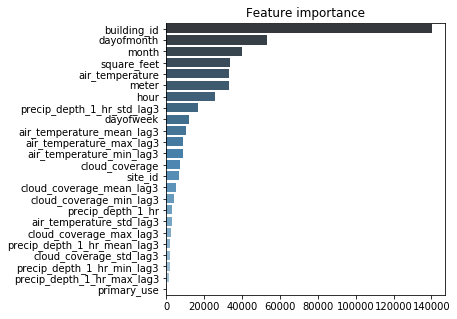

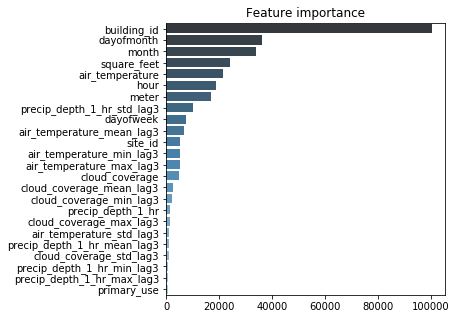

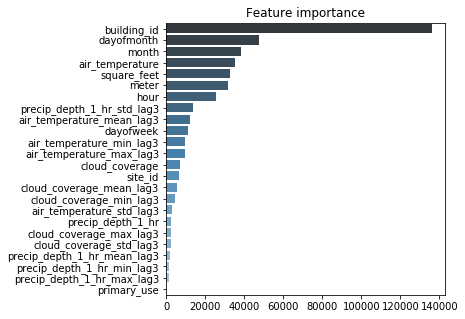

In [0]:
# plotting feature importance - building id, day of month, month, area of building and air temperature are the most important predictors
for model in models:
  lg_ft_imp = pd.Series(data=model.feature_importance(), index=train_all.loc[:,train_all.columns!='meter_reading'].columns).sort_values(ascending=False)[:25]
  plt.figure(figsize=(5,5))
  plt.title("Feature importance")
  ax = sns.barplot(y=lg_ft_imp.index, x=lg_ft_imp.values, palette="Blues_d", orient='h')

In [0]:
gc.collect()

0

In [0]:
# fit_lgbm = lgb.train(params, trn_data, num_boost_round= 1000, valid_sets = [trn_data, val_data], verbose_eval=50, 
#                 early_stopping_rounds = 50)

In [0]:
# import seaborn as sns
# lg_ft_imp = pd.Series(data=fit_lgbm.feature_importance(), index=train_h1.loc[:,train_h1.columns!='meter_reading'].columns).sort_values(ascending=False)[:25]
# plt.figure(figsize=(5,5))
# plt.title("Feature importance")
# ax = sns.barplot(y=lg_ft_imp.index, x=lg_ft_imp.values, palette="Blues_d", orient='h')

In [0]:
# fit_lgbm = lgb.train(lgbm_model, trn_data, num_boost_round= 5000, valid_sets = [trn_data, val_data], verbose_eval=500, 
#                 early_stopping_rounds = 100, categorical_feature = categorical_feature)

In [0]:
# import seaborn as sns
# lg_ft_imp = pd.Series(data=fit_lgbm.feature_importance(), index=train_h1.loc[:,train_h1.columns!='meter_reading'].columns).sort_values(ascending=False)[:25]
# plt.figure(figsize=(5,5))
# plt.title("Feature importance")
# ax = sns.barplot(y=lg_ft_imp.index, x=lg_ft_imp.values, palette="Blues_d", orient='h')

In [0]:
# ## Second Half
# val_data2 = lgb.Dataset(train_h1.loc[:,train_h1.columns!='meter_reading'], label=train_h1['meter_reading'],categorical_feature=categorical_feature, free_raw_data=False)
# trn_data2= lgb.Dataset(train_h2.loc[:,train_h2.columns!='meter_reading'], label=train_h2['meter_reading'],categorical_feature=categorical_feature, free_raw_data=False)

# fit_lgbm2 = lgb.train(params, trn_data2, num_boost_round= 1000, valid_sets = [trn_data2, val_data2], verbose_eval=50, 
#                 early_stopping_rounds = 50)

# import seaborn as sns
# lg_ft_imp2 = pd.Series(data=fit_lgbm2.feature_importance(), index=train_h1.loc[:,train_h1.columns!='meter_reading'].columns).sort_values(ascending=False)[:25]
# plt.figure(figsize=(5,5))
# plt.title("Feature importance")
# ax = sns.barplot(y=lg_ft_imp2.index, x=lg_ft_imp2.values, palette="Blues_d", orient='h')

## Prediction

In [0]:
# freeing up unused memory
gc.collect()

0

In [0]:
# running and ensembling prediction; taking exponent of the results since we predicted in log scale
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# load submission file
submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [0]:
submission.head()

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [0]:
#update submission file to be uploaded on kaggle
submission['meter_reading'] = np.clip(results, 0, a_max=None)

In [0]:
submission.head()

,row_id,meter_reading
0,0,154.736805
1,1,53.905095
2,2,10.484195
3,3,235.402696
4,4,787.541192


In [0]:
test.shape, submission.shape

((41697600, 24), (41697600, 2))

In [0]:
len(submission[submission['meter_reading']==0])

158504

In [0]:
# Kaggle submission
# leaderboard - https://www.kaggle.com/c/ashrae-energy-prediction/leaderboard 
# username: Manas
submission.to_csv('submission29Nov_3fold_regularized.csv', index=False)

In [0]:
# submission= pd.read_csv(DATA_DIR+'submission29Nov_3fold_regularized.csv')
# test = pd.read_csv(DATA_DIR+'test.csv')

In [0]:
# let's plot the predictions 
test_pred = pd.concat([test,submission], axis = 1)

train_building_23 = train_all[train_all['building_id'] == 1298].copy()
test_pred_building_23 = test_pred[test_pred['building_id'] == 1298].copy()

In [0]:
meter_0_data = train_building_23[train_building_23['meter']==0].copy()
meter_0_data['date'] = meter_0_data['timestamp'].dt.date
meter_0_train = meter_0_data.groupby('date')['meter_reading'].sum().to_frame().reset_index()

meter_1_data = train_building_23[train_building_23['meter']==1].copy()
meter_1_data['date'] = meter_1_data['timestamp'].dt.date
meter_1_train = meter_1_data.groupby('date')['meter_reading'].sum().to_frame().reset_index()

meter_2_data = train_building_23[train_building_23['meter']==2].copy()
meter_2_data['date'] = meter_2_data['timestamp'].dt.date
meter_2_train = meter_2_data.groupby('date')['meter_reading'].sum().to_frame().reset_index()

meter_3_data = train_building_23[train_building_23['meter']==3].copy()
meter_3_data['date'] = meter_3_data['timestamp'].dt.date
meter_3_train = meter_3_data.groupby('date')['meter_reading'].sum().to_frame().reset_index()

meter_0_train.shape, meter_1_train.shape, meter_2_train.shape, meter_3_train.shape, 

((345, 2), (366, 2), (366, 2), (366, 2))

In [0]:
test_pred_building_23["timestamp"] = pd.to_datetime(test_pred_building_23["timestamp"],format="%Y-%m-%d %H:%M:%S")
meter_0_data = test_pred_building_23[test_pred_building_23['meter']==0].copy()
meter_0_data['date'] = meter_0_data['timestamp'].dt.date
meter_0_test = meter_0_data.groupby('date')['meter_reading'].sum().to_frame().reset_index()

meter_1_data = test_pred_building_23[test_pred_building_23['meter']==1].copy()
meter_1_data['date'] = meter_1_data['timestamp'].dt.date
meter_1_test = meter_1_data.groupby('date')['meter_reading'].sum().to_frame().reset_index()

meter_2_data = test_pred_building_23[test_pred_building_23['meter']==2].copy()
meter_2_data['date'] = meter_2_data['timestamp'].dt.date
meter_2_test = meter_2_data.groupby('date')['meter_reading'].sum().to_frame().reset_index()

meter_3_data = test_pred_building_23[test_pred_building_23['meter']==3].copy()
meter_3_data['date'] = meter_3_data['timestamp'].dt.date
meter_3_test = meter_3_data.groupby('date')['meter_reading'].sum().to_frame().reset_index()

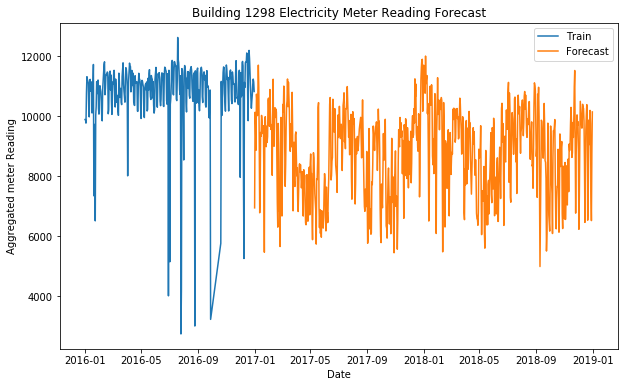

In [0]:
plt.figure(figsize=(10,6));
plt.plot(pd.merge(meter_0_train.set_index('date'), meter_0_test.set_index('date'), how = 'outer', left_index=True, right_index=True));
plt.ylabel('Aggregated meter Reading');
plt.xlabel('Date');
plt.title('Building 1298 Electricity Meter Reading Forecast')
plt.legend(('Train','Forecast'));

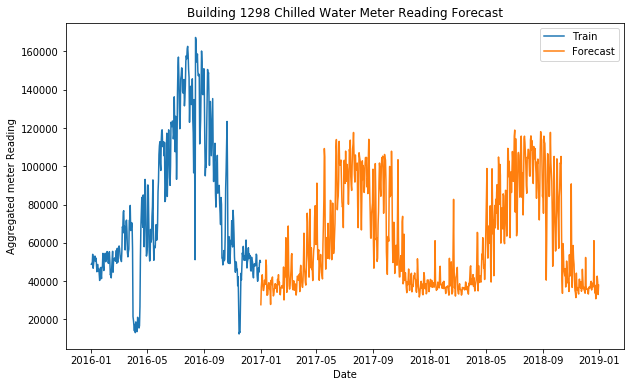

In [0]:
plt.figure(figsize=(10,6));
plt.plot(pd.merge(meter_1_train.set_index('date'), meter_1_test.set_index('date'), how = 'outer', left_index=True, right_index=True));
plt.ylabel('Aggregated meter Reading');
plt.xlabel('Date');
plt.title('Building 1298 Chilled Water Meter Reading Forecast');
plt.legend(('Train','Forecast'));

Text(0.5, 1.0, 'Building 1298 Steam Meter Reading Forecast')

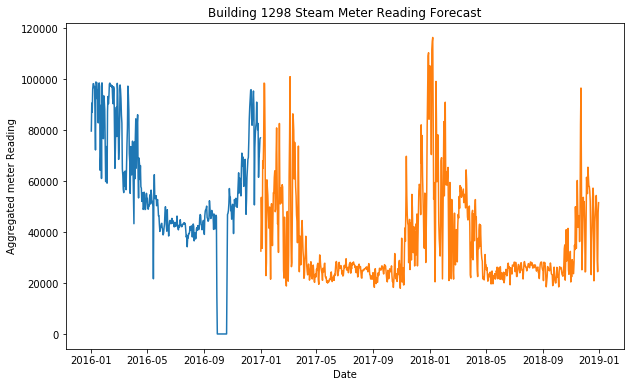

In [0]:
plt.figure(figsize=(10,6));
plt.plot(pd.merge(meter_2_train.set_index('date'), meter_2_test.set_index('date'), how = 'outer', left_index=True, right_index=True));
plt.ylabel('Aggregated meter Reading');
plt.xlabel('Date');
plt.title('Building 1298 Steam Meter Reading Forecast')

Text(0.5, 1.0, 'Building 1298 Hot Water Meter Reading Forecast')

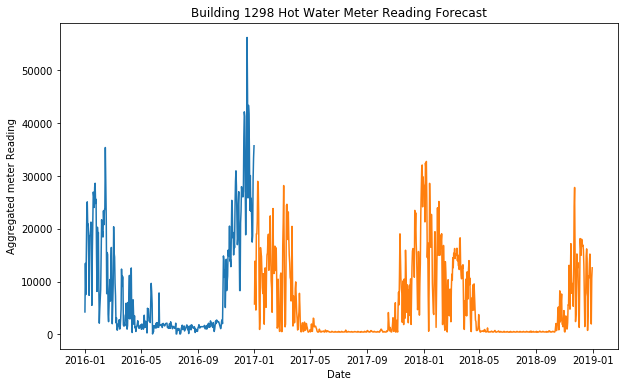

In [0]:
plt.figure(figsize=(10,6));
plt.plot(pd.merge(meter_3_train.set_index('date'), meter_3_test.set_index('date'), how = 'outer', left_index=True, right_index=True));
plt.ylabel('Aggregated meter Reading');
plt.xlabel('Date');
plt.title('Building 1298 Hot Water Meter Reading Forecast')

In [0]:
# for H1 vs H2 model - we are not using it anymore

# test_2017 = test[test['year']==2017]
# test_2017.drop(columns = ['year'], inplace = True)
# test_2018 = test[test['year']==2018]
# test_2018.drop(columns = ['year'], inplace = True)

# pred_lgbm1_2017 = fit_lgbm.predict(test_2017, num_iteration=fit_lgbm.best_iteration)
# gc.collect()

# pred_lgbm1_2018 = fit_lgbm.predict(test_2018, num_iteration=fit_lgbm.best_iteration)
# gc.collect()

# pred_lgbm2_2017 = fit_lgbm2.predict(test_2017, num_iteration=fit_lgbm2.best_iteration)
# gc.collect()

# pred_lgbm2_2018 = fit_lgbm2.predict(test_2018, num_iteration=fit_lgbm2.best_iteration)
# gc.collect()

# train_all.boxplot(column='meter_reading')

# frames1 = [expm1(pd.DataFrame(pred_lgbm1_2017)), expm1(pd.DataFrame(pred_lgbm1_2018))]
# frames2 = [expm1(pd.DataFrame(pred_lgbm2_2017)), expm1(pd.DataFrame(pred_lgbm2_2018))]

# x = (pd.concat([pd.concat(frames1), pd.concat(frames2)], axis = 1)).mean(axis=1).to_frame()

# submission['meter_reading'] = x[0].values

## Catboost

In [0]:
#install catboost
!pip install catboost;
from catboost import CatBoostRegressor, Pool, cv

     |████████████████████████████████| 63.6MB 44.6MB/s 


In [0]:
# create a copy of dataset since we need to change the datatype of categorical features and hence we won't disturb the original dataframe
gc.collect()
cat_train = train_all.copy()
cat_train.fillna(0, inplace = True)
cat_train['primary_use'] = cat_train['primary_use'].astype('str')

In [0]:
# initialize catboost
model = CatBoostRegressor( max_depth=8,
                           loss_function="RMSE",
                           eval_metric= 'RMSE',
                           learning_rate=0.05,
                           iterations=500,
                           task_type= 'GPU'
                         )

In [0]:
# create X and y data
features = cat_train.loc[:,cat_train.columns!='meter_reading']
target = cat_train['meter_reading']

del cat_train

In [0]:
# running the model
gc.collect()

kf = KFold(n_splits=2)
models = []
i =0
for train_index,test_index in kf.split(features):
    print(i)
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = target.loc[test_index]
    
    _train = Pool(train_features, label=train_target,cat_features= categorical_feature)
    _valid = Pool(test_features, label=test_target,cat_features= categorical_feature)
    
    model_cb = model.fit(_train,verbose_eval=100, early_stopping_rounds=100,eval_set=[_valid],use_best_model=True,plot=False)
    models.append(model_cb)
    del train_features, train_target, test_features, test_target, _train, _valid
    gc.collect()
    i+=1

0
0:	learn: 1.9783647	test: 2.0268177	best: 2.0268177 (0)	total: 1.27s	remaining: 10m 34s
100:	learn: 0.9333034	test: 1.3913871	best: 1.3913871 (100)	total: 1m 50s	remaining: 7m 15s
200:	learn: 0.8638624	test: 1.3410349	best: 1.3410349 (200)	total: 3m 33s	remaining: 5m 17s
300:	learn: 0.8241360	test: 1.3141704	best: 1.3141704 (300)	total: 5m 26s	remaining: 3m 35s
400:	learn: 0.7975348	test: 1.2898886	best: 1.2897927 (399)	total: 7m 16s	remaining: 1m 47s
499:	learn: 0.7760605	test: 1.2729138	best: 1.2729138 (499)	total: 9m 6s	remaining: 0us
bestTest = 1.272913833
bestIteration = 499
1
0:	learn: 1.9841479	test: 2.0113242	best: 2.0113242 (0)	total: 1.33s	remaining: 11m 6s
100:	learn: 0.9308606	test: 1.3549930	best: 1.3549930 (100)	total: 1m 49s	remaining: 7m 14s
200:	learn: 0.8583420	test: 1.2972314	best: 1.2972314 (200)	total: 3m 34s	remaining: 5m 18s
300:	learn: 0.8162405	test: 1.2768113	best: 1.2768113 (300)	total: 5m 22s	remaining: 3m 33s
400:	learn: 0.7865217	test: 1.2771156	best: 1.

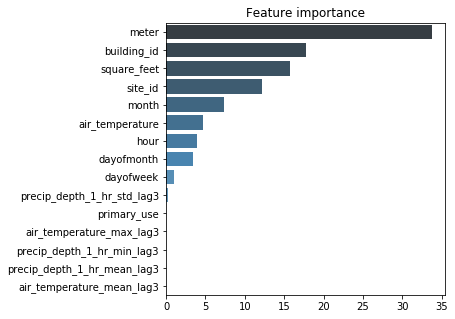

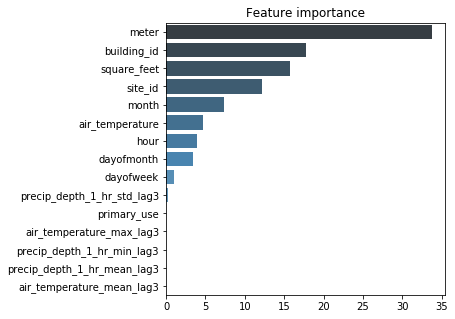

In [0]:
#plotting feature importance
for model in models:
  cat_ft_imp = pd.Series(data=model.get_feature_importance(), index=features.columns).sort_values(ascending=False)[:15]
  plt.figure(figsize=(5,5))
  plt.title("Feature importance")
  ax = sns.barplot(y=cat_ft_imp.index, x=cat_ft_imp.values, palette="Blues_d", orient='h')

In [0]:
# run prediction and ensemble results
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test)) / len(models)
    else:
        results += np.expm1(model.predict(test)) / len(models)
    del model
    gc.collect()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# update submission file
submission = pd.read_csv(DATA_DIR+'sample_submission.csv')
submission['meter_reading'] = np.clip(results, 0, a_max=None)

In [0]:
# Kaggle submission
# leaderboard - https://www.kaggle.com/c/ashrae-energy-prediction/leaderboard 
# username: Manas
submission.to_csv('catboost24Nov.csv', index=False)